# Fluctuating Intensities From ROIs
## Read ROI regions from OMERO and analyse fluctuations of pixel intensities
### Laura Cooper 03/08/2020

## Prerequisites
This notebook assumes the default group for the user in OMERO is roylelab and that you are connected to the VPN.
### Import Packages

In [4]:
from omero.gateway import BlitzGateway
import getpass
import numpy as np
from scipy import fft, ndimage
import matplotlib.pyplot as plt
import csv
import omero
import omero.model

### Define functions
#### Get details of ROIs from OMERO

In [7]:
# Adapted from Slide_Scanner_Images_From_ROIs.py
# https://github.com/will-moore/omero_scripts/blob/master/omero/util_scripts/Slide_Scanner_Images_From_ROIs.py
def getImageAndRectangles(conn, imageId):
    """
    Returns a list of (x, y, width, height, zStart, zStop, tStart, tStop)
    of each rectangle ROI in the image
    Input: conn       OMERO BlitzGateway connection
           imageID    OMERO ID of image
    """

    rois = []
    roi_ids = []

    roiService = conn.getRoiService()
    result = roiService.findByImage(imageId, None)
    image = conn.getObject("Image", imageId)
    for roi in result.rois:
        zStart = None
        zEnd = 0
        tStart = None
        tEnd = 0
        x = None
        for shape in roi.copyShapes():
            if type(shape) == omero.model.RectangleI:
                #For all z and all time
                zStart=0
                zEnd=image.getSizeZ()
                tStart=0
                tEnd=image.getSizeT()
                if x is None:   # get x, y, width, height for first rect only
                    x = int(shape.getX().getValue())
                    y = int(shape.getY().getValue())
                    width = int(shape.getWidth().getValue())
                    height = int(shape.getHeight().getValue())
        # if we have found any rectangles at all...
        if zStart is not None:
            rois.append((x, y, width, height, zStart, zEnd, tStart, tEnd))
            roi_ids.append(roi.getId().getValue())

    return rois, image, roi_ids

#### Convert image stack to np.array, only reading data from within ROI

In [8]:
def get_z_stack(image, roi):
    """
    Convert OMERO image object to numpy array
    Input: img  OMERO image object
           c    number of colour channls
           t    number of time steps
    """
    z, t, c = 0, 0, 0                     # first plane of the image
    pixels = image.getPrimaryPixels() # pixel wrapper of image
    plane=np.zeros([roi[7],roi[3],roi[2]]) # Preallocate numpy array
    for T in range(roi[7]):                             # For the first three time steps, get a 2D numpy array 
        plane[T,:,:] = pixels.getTile(z, c, T,roi[0:4]) # combine into 3D array
    return plane #Read in data one plane at a time

#### Calculate turbulence statistics

In [9]:
def turb_stats(f, Fs):
    """
    Get turblence statistics for each pixel
    Input: f     numpy array of image
           Fs    sample frequency
    """
    L=np.shape(f)
    # mean velocity over time for every pixel
    ind_u_bar=np.mean(f, axis = 0); #mean over time
    # Reynolds decomposition to calculate turbulent fluctuations
    ind_u_fluct=np.subtract(f,ind_u_bar)
    #Turblence Strength
    ind_u_rms=np.std(ind_u_fluct, axis = 0) #standard deviation over time
    # Frequency spectrum
    ind_u_fft=fft.fft(ind_u_fluct, axis = 0) #fast fourier transform in time
    P2=abs(ind_u_fft/L[0]) #2 sided spectrum
    P1=P2[0:int(L[0]/2)]; #1 sided spectrum
    P1[1:len(P1)-1]=2*P1[1:len(P1)-1];
    fd=Fs*np.arange(0,int(L[0]/2),1)/L[0]; #Freqency domain
    return ind_u_bar, ind_u_rms, P1, fd

I have named the variables here as they would be called in a turbulence study (as this is want makes sense to me). To relate them to the current problem:
- Mean velocity is mean intensity
- Turbulent fluctuations are intensity flucuations
- Turblence Strength is the standard deviation of the set of intensity fluctuations

#### Calculate tubulence statistics for all images in a dataset

In [10]:
def Fluc_ds(image, rois, Fs):
    """
    Get mean turblence statistics for each image
    Input: image     OMERO image object
           rois      Regions of interest, list of the form (x, y, width, height, zStart, zStop, tStart, tStop)
           Fs        Sampling frequency
    """
    Iid = image.getId()
    numTimeSteps=image.getSizeT()
    f1 = get_z_stack(image, rois)
    f = med_sub(f1)
    ind_u_bar, ind_u_rms, P1, fd = turb_stats(f, Fs) #Assumes sample frequency same for all images
    #Average in space         
    u_bar=np.mean(ind_u_bar, axis=(0,1))
    u_rms = np.mean(ind_u_rms, axis=(0,1))
    P1_mean=np.mean(P1,axis=(1,2))
    fd_all=fd
    return Iid, u_bar, u_rms, P1_mean, fd_all

#### Apply median filter and subtract

In [11]:
def med_sub(image):
    final=np.zeros(image.shape)
    for z in range(image.shape[0]):
        im_med = ndimage.median_filter(image[z,:,:], 2)
        final[z,:,:]=np.subtract(image[z,:,:],im_med)
    return final

#### Write dictionary to file

In [79]:
def dict2csv(dictionary, filename):
    """
    write dictionary to csv file
    Input: dictionary     A dictionary 
           filename       name of output file
    """ 
    with open(filename, 'w') as f:
        for key in dictionary:
            q=str(dictionary[key].tolist())
            f.write("%s,%s\n"%(key,q[1:-1]))

#### Read dictionary from file

In [116]:
def csv2dict(filename):
    """
    write dictionary to csv file
    Input: filename       name of input file
    """
    with open(filename, mode='r') as infile:
        reader = csv.reader(infile)
        with open('coors_new.csv', mode='w') as outfile:
            writer = csv.writer(outfile)
            mydict = {int(rows[0]):np.array(rows[1:], dtype=np.float64) for rows in reader}
    return mydict

## Method
### Connect to OMERO

In [14]:
username = input('Username: ') #Request user to enter OMERO username
password = getpass.getpass(prompt='Password: ') #Request user to enter OMERO password
conn = BlitzGateway(username, password, host='camdu.warwick.ac.uk', port=4064) #Use details to connect to OMERO server
conn.connect() #Returns true when connected

Username: u1675160
Password: ········


True

### Get OMERO IDs
Get the image we are interested in

In [15]:
imageID=257295
image = conn.getObject("Image", imageID)
print(image.getName())

200729 GFP-TPD54 Fast imaging 004.nd2


Put names and IDs in dictionary to make it easy to call required datasets.

In [17]:
#Get ROIs from image
rois, image, roi_ids = getImageAndRectangles(conn, imageID)

Set up dictionarys for results using the same names as the datasets. _Im here means these are the mean results for each roi

In [18]:
ROIs=dict(zip(roi_ids[:], rois[:]))
ImageIDs=dict.fromkeys(roi_ids[:])
Mean_Vel_Im=dict.fromkeys(roi_ids[:])
TurbStreng_Im=dict.fromkeys(roi_ids[:])
Amp_Im=dict.fromkeys(roi_ids[:])
Freq_Im=dict.fromkeys(roi_ids[:])

Calculate the turbulence statistics for each image

In [19]:
for roi in ROIs:
    print(roi)
    ImageIDs[roi], Mean_Vel_Im[roi], TurbStreng_Im[roi], Amp_Im[roi], Freq_Im[roi] = Fluc_ds(image, ROIs[roi], 80)

4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065


Close connection to OMERO

In [20]:
conn.close()

Write results to file

In [81]:
dict2csv(Mean_Vel_Im,'Mean_Vel.csv')
dict2csv(TurbStreng_Im,'TurbStreng.csv')
dict2csv(Amp_Im,'Amp.csv')
dict2csv(Freq_Im,'Freq.csv')

## Results

In [126]:
## Uncomment to read results from files
#Mean_Vel_Im=csv2dict('Mean_Vel.csv')
#TurbStreng_Im=csv2dict('TurbStreng.csv')
#Amp_Im=csv2dict('Amp.csv')
#Freq_Im=csv2dict('Freq.csv')

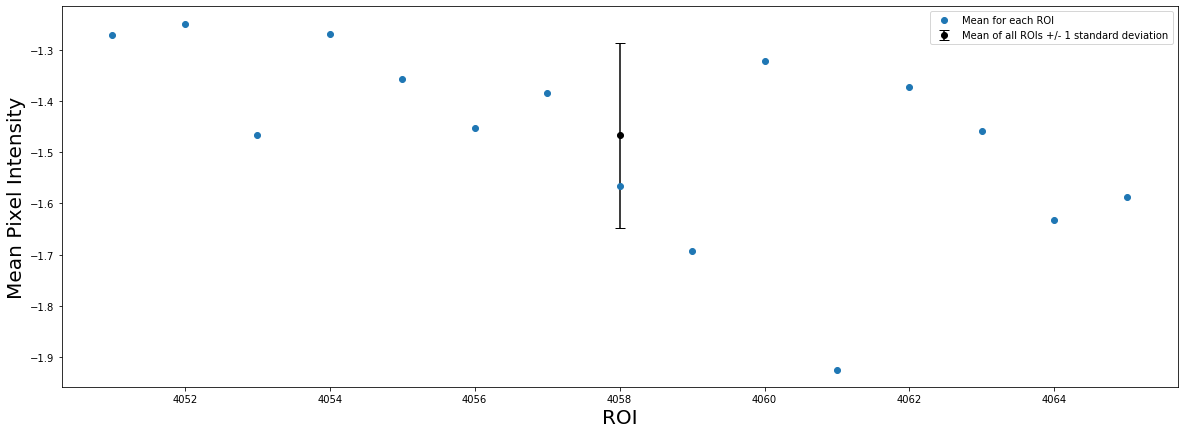

In [180]:
fig, axs = plt.subplots(1,1,figsize=(20,7))
axs.errorbar(Mean_Vel_Im.keys(), list(Mean_Vel_Im.values()), yerr=None, xerr=None,fmt='o', label="Mean for each ROI")
axs.errorbar(4058, np.mean(list(Mean_Vel_Im.values())), yerr=np.std(list(Mean_Vel_Im.values())),fmt='o', capsize=5, color='black', label="Mean of all ROIs +/- 1 standard deviation")
axs.set_ylabel('Mean Pixel Intensity',fontsize=20)
axs.set_xlabel('ROI',fontsize=20)
axs.legend()
plt.show()

I don't know if there was anything special about it, but you may want to look at ROI 4061 - it looks like a outlier

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
Mean_Vels=[]
Mean_TS=[]
for i,key in enumerate(all_results):
    Mean_Vels.append(np.mean(all_results[key]['Mean_Vel']))
    Mean_TS.append(np.mean(all_results[key]['TurbStreng']))
ax.bar(np.arange(len(Mean_Vels)), Mean_Vels, yerr=Mean_TS, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Pixel Intensity',fontsize=20)
ax.set_xticks(np.arange(len(Mean_Vels)))
ax.set_xticklabels(all_results.keys(), fontsize=12)
ax.set_title('Mean Pixel Intensity of Each Dataset',fontsize=20)
fig.tight_layout()
plt.show()
fig.savefig('MeanIntensity.png');

In [138]:
Mean_Vel_Im.values()

dict_values([-1.2712470703125, -1.2491028846153847, -1.4661033163265305, -1.2684766357421873, -1.3568822998046874, -1.4528406249999999, -1.383891688239645, -1.5658418367346938, -1.6931409438775509, -1.3230578369140624, -1.9239764030612245, -1.3733753906250001, -1.458382451923077, -1.6317315051020407, -1.5878966346153847])

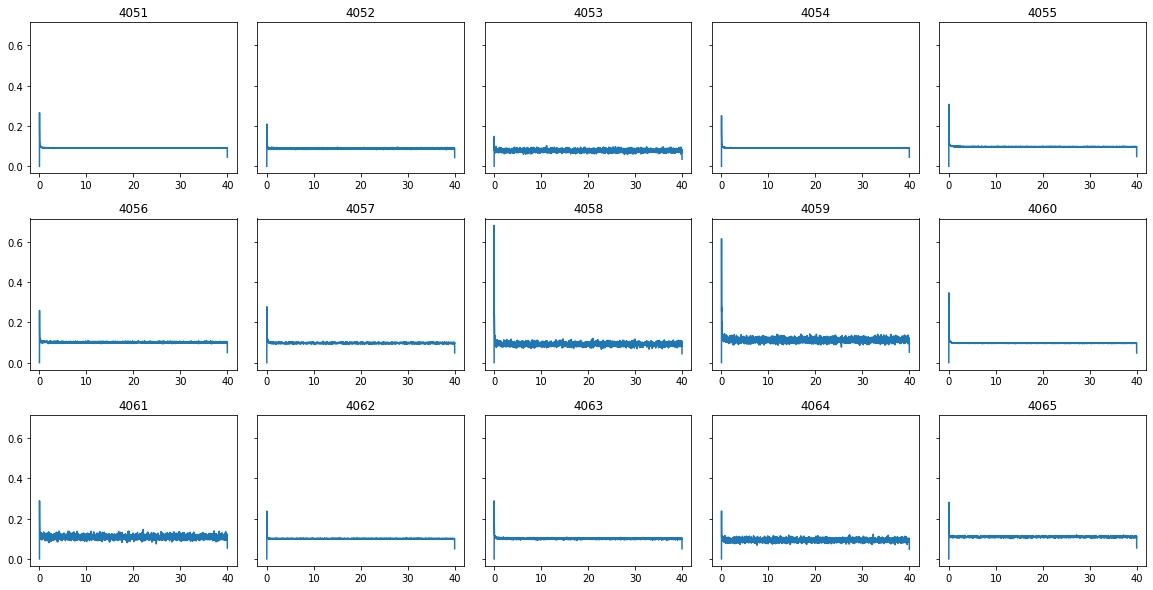

In [220]:
fig, axs = plt.subplots(3,5,figsize=(20,10),sharey=True)
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()
for i,key in enumerate(Amp_Im):
    axs[i].plot(Freq_Im[key],Amp_Im[key])
    axs[i].set_title(key)

In [209]:
for key in Amp_Im:
    pos = np.where(Amp_Im[key]==max(Amp_Im[key]))
    print('Frequency of peak for ROI ', str(key), ': ',Freq_Im[key][pos])

Frequency of peak for ROI  4051 :  [0.0125]
Frequency of peak for ROI  4052 :  [0.0125]
Frequency of peak for ROI  4053 :  [0.0125]
Frequency of peak for ROI  4054 :  [0.0125]
Frequency of peak for ROI  4055 :  [0.0125]
Frequency of peak for ROI  4056 :  [0.0125]
Frequency of peak for ROI  4057 :  [0.0125]
Frequency of peak for ROI  4058 :  [0.0125]
Frequency of peak for ROI  4059 :  [0.0125]
Frequency of peak for ROI  4060 :  [0.0125]
Frequency of peak for ROI  4061 :  [0.0125]
Frequency of peak for ROI  4062 :  [0.0125]
Frequency of peak for ROI  4063 :  [0.0125]
Frequency of peak for ROI  4064 :  [0.0125]
Frequency of peak for ROI  4065 :  [0.0125]


The peak is at 0.0125 which is 1/80, so this is may related to the microscope set up, i.e. background noise